In [190]:
#From https://github.com/PacktPublishing/Causal-Inference-and-Discovery-in-Python/blob/main/Chapter_13.ipynb

import os
os.environ['CASTLE_BACKEND'] = 'pytorch'

from collections import OrderedDict
import warnings

import numpy as np
import networkx as nx

from scipy import linalg 

from sklearn.linear_model import LinearRegression

import castle
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import DAG, IIDSimulation 

from castle.algorithms import PC, GES
from castle.algorithms import ANMNonlinear, ICALiNGAM, DirectLiNGAM
from castle.algorithms import Notears, NotearsNonlinear, GOLEM

from castle.common.priori_knowledge import PrioriKnowledge

from castle.common.independence_tests import hsic_test

import matplotlib.pyplot as plt

from dowhy import gcm
import pandas as pd

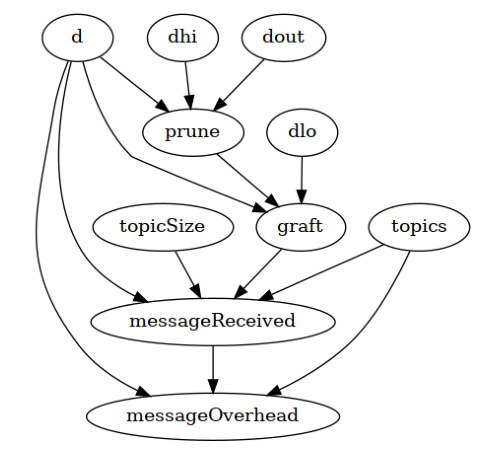

In [191]:
#Causal graph
causal_graph = nx.DiGraph([('d', 'messageReceived'),
                           ('d', 'graft'),
                           ('d', 'prune'),
                           ('dlo', 'graft'),
                           ('dhi', 'prune'),
                           ('dout', 'prune'),
                           # ('interval', 'graft'),
                           # ('interval', 'prune'),
                           ('prune', 'graft'),
                           ('messageReceived', 'messageOverhead'),
                           ('graft','messageReceived'),
                           ('topics', 'messageReceived'),
                           ('d', 'messageOverhead'),
                           ('topicSize', 'messageReceived'),
                           # ('topicSize','prune'),
                           ('topics', 'messageOverhead'),
                         ])


G=gcm.util.plot(causal_graph, figure_size=[6, 8])
nx.write_adjlist(causal_graph, "./AdjLists/manual.adjlist")

A = nx.nx_agraph.to_agraph(causal_graph)

A.layout("dot")

A.get_node('d').attr['style']='bold'
A.get_node('dlo').attr['style']='bold'
A.get_node('dhi').attr['style']='bold'
A.get_node('dout').attr['style']='bold'
# A.get_node('interval').attr['style']='bold'
A.get_node('topicSize').attr['style']='bold'
A.get_node('topics').attr['style']='bold'


A.get_node('messageOverhead').attr['style']='filled'
A.get_node('messageOverhead').attr['penwidth']=2


A.draw("./Graphs/manual.png")#, prog="dot")
# nx.write_adjlist(H, "pc.adjlist")

In [192]:
#From digraph to adjancency matrix

# true_causal_matrix = nx.adjacency_matrix(causal_graph)
true_causal_matrix = nx.to_numpy_array(causal_graph)

print(true_causal_matrix)
print(causal_graph.nodes)

[[0. 1. 1. 1. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
['d', 'messageReceived', 'graft', 'prune', 'dlo', 'dhi', 'dout', 'messageOverhead', 'topics', 'topicSize']


In [193]:
#Treat dataset

#Import data 
# data = pd.read_csv('../datasets/consolidated.csv',header=0, index_col=0)
data = pd.read_csv('../../Datasets/Networkwise/consolidated_5s.csv',header=0, index_col=0)
consolidated = pd.DataFrame(data)


consolidated = consolidated.drop(columns=['experiment', 'topology'])#, 'messageBandwidth'])#, 'gossipBandwidth'])#, 'messageDuplicated'])#, 'n_nodes', 'consensus', 'messageDuplicated'])
# consolidated = consolidated.loc[consolidated['totalBandwidth'] > 0]
# consolidated.head(100)

consolidateddiff = consolidated.dropna().dropna()

X = consolidateddiff[['d', 'messageReceived', 'graft', 'prune', 'dlo', 'dhi', 'dout', 'messageOverhead', 'topics', 'topicSize']].to_numpy()
consolidated = consolidateddiff[['d', 'messageReceived', 'graft', 'prune', 'dlo', 'dhi', 'dout', 'messageOverhead', 'topics', 'topicSize']]


# X = consolidateddiff[['d', 'messageReceived', 'graft', 'prune', 'dlo', 'dhi', 'dout', 'interval', 'messageOverhead', 'topics', 'topicSize']].to_numpy()
# consolidated = consolidateddiff[['d', 'messageReceived', 'graft', 'prune', 'dlo', 'dhi', 'dout', 'interval', 'messageOverhead', 'topics', 'topicSize']]

#Rearrange columns according to nodes list
# nodes = causal_graph.nodes

# X = consolidated[['d', 'messageReceived', 'graft', 'prune', 'iwant', 'dlo', 'dhi', 'dscore', 'dlazy', 'ihave', 'dout', 'gossipFactor', 'interval', 'messageOverhead']].to_numpy()

# X = consolidated.to_numpy()
# print(X)
consolidated.head(500)

,d,messageReceived,graft,prune,dlo,dhi,dout,messageOverhead,topics,topicSize
0,8,43.0,0.0,0.0,6,12,2,321.0,1,16
1,8,54.0,0.0,0.0,6,12,2,389.0,1,16
2,8,96.0,0.0,0.0,6,12,2,702.0,1,16
3,8,88.0,0.0,0.0,6,12,2,629.0,1,16
4,8,61.0,0.0,0.0,6,12,2,454.0,1,16
...,...,...,...,...,...,...,...,...,...,...
495,16,18.0,0.0,0.0,8,20,4,62.0,1,16
496,16,56.0,0.0,0.0,8,20,4,250.0,1,16
497,16,50.0,0.0,0.0,8,20,4,175.0,1,16
498,16,58.0,0.0,0.0,8,20,4,239.0,1,16


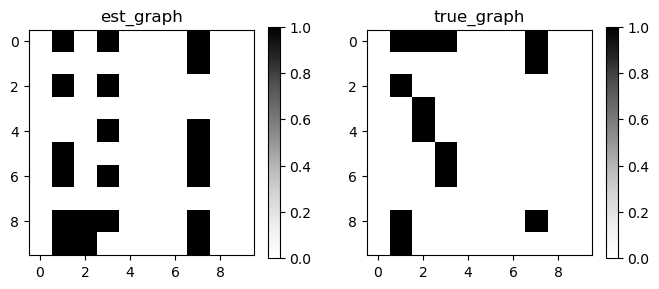

{'fdr': 0.55, 'tpr': 0.6923, 'fpr': 0.3438, 'shd': 14, 'nnz': 20, 'precision': 0.45, 'recall': 0.6923, 'F1': 0.5455, 'gscore': 0.0}


In [194]:
# structure learning
priori = PrioriKnowledge(X.shape[1])
# priori.add_forbidden_edges([
# (0,0),	(0,4),	(0,5),	(0,6),	(0,7),	(0,9),(0,10),
# (1,0),	(1,4),	(1,5),	(1,6),	(1,7),	(1,9),(1,10),
# (2,0),	(2,3),  (2,4),	(2,5),	(2,6),  (2,9),(2,10),
# (3,0),	(3,4),	(3,5),	(3,6),	(3,7),	(3,9),(3,10),
# (4,0),	(4,4),	(4,5),	(4,6),	(4,7),	(4,9),(4,10),
# (5,0),	(5,4),	(5,5),	(5,6),	(5,7),	(5,9),(5,10),
# (6,0),	(6,4),	(6,5),	(6,6),	(6,7),	(6,9),(6,10),
# (7,0),	(7,4),	(7,5),	(7,6),	(7,7),	(7,9),(7,10),
# (8,0),	(8,1),  (8,4),	(8,5),	(8,6),	(8,7),(8,9),(8,10),
# (9,0),	(9,4),	(9,5),	(9,6),	(9,7),	(9,9),(9,10),
# (10,0), (10,4), (10,5), (10,6), (10,7), (10,9)
# ])

# priori.add_forbidden_edges([
# (0,0),	(0,4),	(0,5),	(0,6),	(0,7),	(0,9),(0,10),
# (1,0),	(1,4),	(1,5),	(1,6),	(1,7),	(1,9),(1,10),
# (2,0),	(2,4),  (2,5),	(2,6),	(2,7),  (2,9),(2,10),
# (3,0),	(3,4),	(3,5),	(3,6),	(3,7),	(3,9),(3,10),
# (4,0),	(4,4),	(4,5),	(4,6),	(4,7),	(4,9),(4,10),
# (5,0),	(5,4),	(5,5),	(5,6),	(5,7),	(5,9),(5,10),
# (6,0),	(6,4),	(6,5),	(6,6),	(6,7),	(6,9),(6,10),
# (7,0),	(7,4),	(7,5),	(7,6),	(7,7),	(7,9),(7,10),
# (8,0),  (8,4),	(8,5),	(8,6),	(8,7),  (8,9),(8,10),
# (9,0),	(9,4),	(9,5),	(9,6),	(9,7),	(9,9),(9,10),
# (10,0), (10,4), (10,5), (10,6), (10,7), (10,9)
# ])

priori.add_forbidden_edges([
(0,0),	(0,4),	(0,5),	(0,6),	(0,9),(0,8),
(1,0),	(1,4),	(1,5),	(1,6),	(1,9),(1,8),
(2,0),	(2,4),  (2,5),	(2,6),  (2,9),(2,8),
(3,0),	(3,4),	(3,5),	(3,6),	(3,9),(3,8),
(4,0),	(4,4),	(4,5),	(4,6),	(4,9),(4,8),
(5,0),	(5,4),	(5,5),	(5,6),	(5,9),(5,8),
(6,0),	(6,4),	(6,5),	(6,6),	(6,9),(6,8),
(7,0),	(7,4),	(7,5),	(7,6),	(7,9),(7,8),
(8,0),  (8,4),	(8,5),	(8,6),  (8,9),(8,8),
(9,0),	(9,4),	(9,5),	(9,6),	(9,9),(9,8)
])


# priori.add_required_edges([(1,8)]) 
                           # (18, 16),
                           # (6,2),
                           # (5,3)])
pc = PC(variant='original', priori_knowledge=priori)
pc.learn(X)

# plot predict_dag and true_dag
GraphDAG(pc.causal_matrix, true_causal_matrix, 'result')

# calculate metrics
mt = MetricsDAG(pc.causal_matrix, true_causal_matrix)
print(mt.metrics)

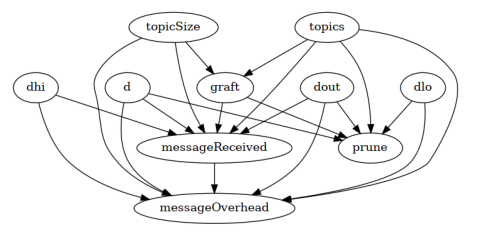

In [195]:
learned_causal_graph = nx.from_numpy_array(pc.causal_matrix, create_using=nx.DiGraph)

mapping = {0:'d',
            1:'messageReceived',
            2:'graft',
            3:'prune',
            4:'dlo',
            5:'dhi',
            6:'dout',
            # 7:'interval',
            7:'messageOverhead',
            8:'topics',
            9:'topicSize'
          }

# nx.set_node_attributes(learned_causal_graph, labels, "name")
H = nx.relabel_nodes(learned_causal_graph, mapping)

# fig, ax = plt.subplots(figsize=(30,30))

G=gcm.util.plot(H, figure_size=[6, 8])

nx.write_adjlist(H, "./AdjLists/pcClassic5s.adjlist")

A = nx.nx_agraph.to_agraph(H)

A.layout("dot")

A.get_node('d').attr['style']='bold'
A.get_node('dlo').attr['style']='bold'
A.get_node('dhi').attr['style']='bold'
A.get_node('dout').attr['style']='bold'
# A.get_node('interval').attr['style']='bold'
A.get_node('topicSize').attr['style']='bold'
A.get_node('topics').attr['style']='bold'


A.get_node('messageOverhead').attr['style']='filled'
A.get_node('messageOverhead').attr['penwidth']=2


A.draw("./Graphs/pcClassic5s.png")#, prog="dot")

# nx.draw(H, 'pc5s.png')

# plt.savefig("PCNoPrioriKnowledge.png") # save as png
# plt.show() # displab

In [196]:
# Adjust graph

H.remove_node('prune')

nx.write_adjlist(H, "./AdjLists/pc5sAdjusted.adjlist")

A = nx.nx_agraph.to_agraph(H)

A.layout("dot")

A.get_node('d').attr['style']='bold'
A.get_node('dlo').attr['style']='bold'
A.get_node('dhi').attr['style']='bold'
A.get_node('dout').attr['style']='bold'
# A.get_node('interval').attr['style']='bold'
A.get_node('topicSize').attr['style']='bold'
A.get_node('topics').attr['style']='bold'


A.get_node('messageOverhead').attr['style']='filled'
A.get_node('messageOverhead').attr['penwidth']=2


A.draw("./Graphs/pc5sAdjusted.png")#, prog="dot")


# Parallel PC

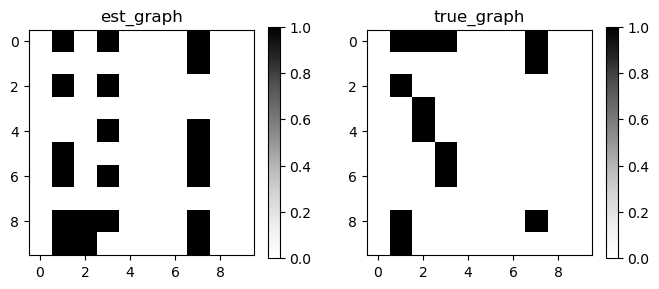

{'fdr': 0.4706, 'tpr': 0.6923, 'fpr': 0.25, 'shd': 11, 'nnz': 17, 'precision': 0.5294, 'recall': 0.6923, 'F1': 0.6, 'gscore': 0.0769}


In [197]:
#Parallel PC

pc_parallel = PC(variant='parallel', priori_knowledge=priori)
pc_parallel.learn(X)

# plot predict_dag and true_dag
GraphDAG(pc.causal_matrix, true_causal_matrix, 'result')

# calculate metrics
mt = MetricsDAG(pc_parallel.causal_matrix, true_causal_matrix)
print(mt.metrics)

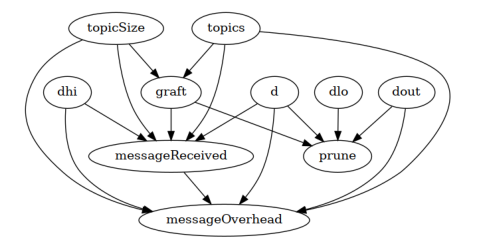

In [198]:
learned_causal_graph = nx.from_numpy_array(pc_parallel.causal_matrix, create_using=nx.DiGraph)

mapping = {0:'d',
            1:'messageReceived',
            2:'graft',
            3:'prune',
            4:'dlo',
            5:'dhi',
            6:'dout',
            # 7:'interval',
            7:'messageOverhead',
            8:'topics',
            9:'topicSize'
          }

# nx.set_node_attributes(learned_causal_graph, labels, "name")
H = nx.relabel_nodes(learned_causal_graph, mapping)

# fig, ax = plt.subplots(figsize=(30,30))

G=gcm.util.plot(H, figure_size=[6, 8])

nx.write_adjlist(H, "./AdjLists/pcParallel5s.adjlist")

A = nx.nx_agraph.to_agraph(H)

A.layout("dot")

A.get_node('d').attr['style']='bold'
A.get_node('dlo').attr['style']='bold'
A.get_node('dhi').attr['style']='bold'
A.get_node('dout').attr['style']='bold'
# A.get_node('interval').attr['style']='bold'
A.get_node('topicSize').attr['style']='bold'
A.get_node('topics').attr['style']='bold'


A.get_node('messageOverhead').attr['style']='filled'
A.get_node('messageOverhead').attr['penwidth']=2


A.draw("./Graphs/pcParallel5s.png")#, prog="dot")

# nx.draw(H, 'pc5s.png')

# plt.savefig("PCNoPrioriKnowledge.png") # save as png
# plt.show() # displab

# Stable PC

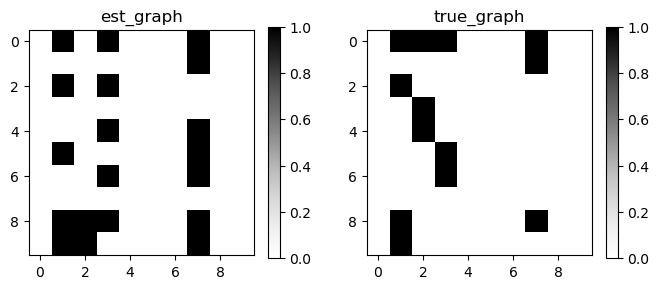

{'fdr': 0.5263, 'tpr': 0.6923, 'fpr': 0.3125, 'shd': 13, 'nnz': 19, 'precision': 0.4737, 'recall': 0.6923, 'F1': 0.5625, 'gscore': 0.0}


In [199]:
#Stable PC

pc_stable = PC(variant='stable', priori_knowledge=priori)
pc_stable.learn(X)

# plot predict_dag and true_dag
GraphDAG(pc_stable.causal_matrix, true_causal_matrix, 'result')

# calculate metrics
mt = MetricsDAG(pc_stable.causal_matrix, true_causal_matrix)
print(mt.metrics)

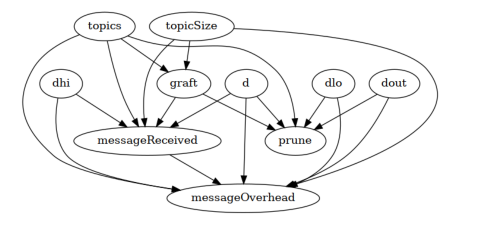

In [200]:
learned_causal_graph = nx.from_numpy_array(pc_stable.causal_matrix, create_using=nx.DiGraph)

mapping = {0:'d',
            1:'messageReceived',
            2:'graft',
            3:'prune',
            4:'dlo',
            5:'dhi',
            6:'dout',
            # 7:'interval',
            7:'messageOverhead',
            8:'topics',
            9:'topicSize'
          }

# nx.set_node_attributes(learned_causal_graph, labels, "name")
H = nx.relabel_nodes(learned_causal_graph, mapping)

# fig, ax = plt.subplots(figsize=(30,30))

G=gcm.util.plot(H, figure_size=[6, 8])

nx.write_adjlist(H, "./AdjLists/pcStable5s.adjlist")

A = nx.nx_agraph.to_agraph(H)

A.layout("dot")

A.get_node('d').attr['style']='bold'
A.get_node('dlo').attr['style']='bold'
A.get_node('dhi').attr['style']='bold'
A.get_node('dout').attr['style']='bold'
# A.get_node('interval').attr['style']='bold'
A.get_node('topicSize').attr['style']='bold'
A.get_node('topics').attr['style']='bold'


A.get_node('messageOverhead').attr['style']='filled'
A.get_node('messageOverhead').attr['penwidth']=2


A.draw("./Graphs/pcStable5s.png")#, prog="dot")

# nx.draw(H, 'pc5s.png')

# plt.savefig("PCNoPrioriKnowledge.png") # save as png
# plt.show() # displab

# Differences between PC variants

In [217]:
classic = nx.read_adjlist("./AdjLists/pcClassic5s.adjlist", create_using=nx.DiGraph)
parallel = nx.read_adjlist("./AdjLists/pcParallel5s.adjlist", create_using=nx.DiGraph)
stable = nx.read_adjlist("./AdjLists/pcStable5s.adjlist", create_using=nx.DiGraph)

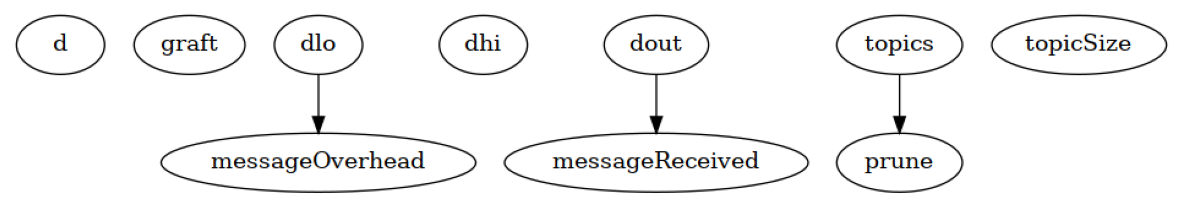

In [219]:
diff_c_p = nx.difference(classic, parallel)

A = nx.nx_agraph.to_agraph(diff_c_p)

A.layout("dot")

A.get_node('d').attr['style']='bold'
A.get_node('dlo').attr['style']='bold'
A.get_node('dhi').attr['style']='bold'
A.get_node('dout').attr['style']='bold'
# A.get_node('interval').attr['style']='bold'
A.get_node('topicSize').attr['style']='bold'
A.get_node('topics').attr['style']='bold'


A.get_node('messageOverhead').attr['style']='filled'
A.get_node('messageOverhead').attr['penwidth']=2

G=gcm.util.plot(diff_c_p, figure_size=[15, 10])
A.draw("./Graphs/diff_classic_parallel.png")#, prog="dot")


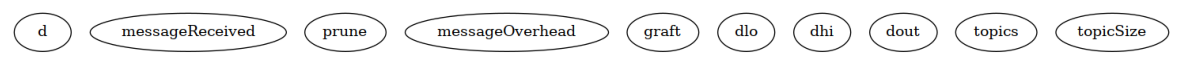

In [220]:
diff_p_c = nx.difference(parallel, classic)

A = nx.nx_agraph.to_agraph(diff_p_c)

A.layout("dot")

A.get_node('d').attr['style']='bold'
A.get_node('dlo').attr['style']='bold'
A.get_node('dhi').attr['style']='bold'
A.get_node('dout').attr['style']='bold'
# A.get_node('interval').attr['style']='bold'
A.get_node('topicSize').attr['style']='bold'
A.get_node('topics').attr['style']='bold'


A.get_node('messageOverhead').attr['style']='filled'
A.get_node('messageOverhead').attr['penwidth']=2

G=gcm.util.plot(diff_p_c, figure_size=[15, 10])
A.draw("./Graphs/diff_parallel_classic.png")#, prog="dot")


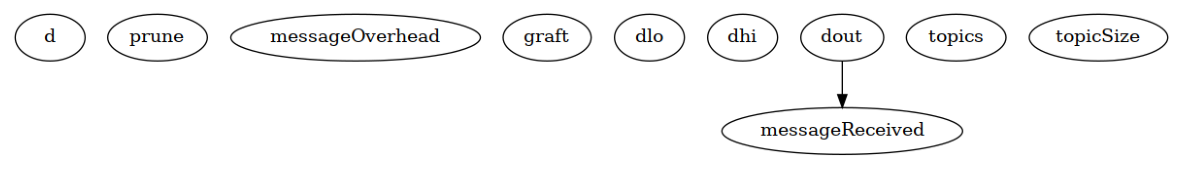

In [221]:
diff_c_s = nx.difference(classic, stable)

A = nx.nx_agraph.to_agraph(diff_c_s)

A.layout("dot")

A.get_node('d').attr['style']='bold'
A.get_node('dlo').attr['style']='bold'
A.get_node('dhi').attr['style']='bold'
A.get_node('dout').attr['style']='bold'
# A.get_node('interval').attr['style']='bold'
A.get_node('topicSize').attr['style']='bold'
A.get_node('topics').attr['style']='bold'


A.get_node('messageOverhead').attr['style']='filled'
A.get_node('messageOverhead').attr['penwidth']=2

G=gcm.util.plot(diff_c_s, figure_size=[15, 10])
A.draw("./Graphs/diff_classic_stable.png")#, prog="dot")

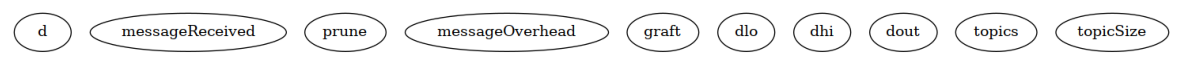

In [222]:
diff_s_c = nx.difference(stable, classic)

A = nx.nx_agraph.to_agraph(diff_s_c)

A.layout("dot")

A.get_node('d').attr['style']='bold'
A.get_node('dlo').attr['style']='bold'
A.get_node('dhi').attr['style']='bold'
A.get_node('dout').attr['style']='bold'
# A.get_node('interval').attr['style']='bold'
A.get_node('topicSize').attr['style']='bold'
A.get_node('topics').attr['style']='bold'


A.get_node('messageOverhead').attr['style']='filled'
A.get_node('messageOverhead').attr['penwidth']=2

G=gcm.util.plot(diff_s_c, figure_size=[15, 10])
A.draw("./Graphs/diff_stable_classic.png")#, prog="dot")

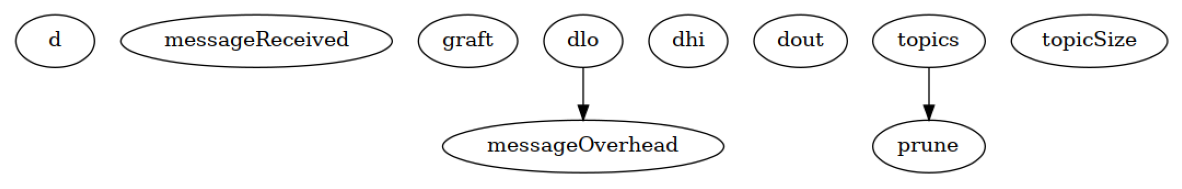

In [223]:
diff_s_p = nx.difference(stable, parallel)

A = nx.nx_agraph.to_agraph(diff_s_p)

A.layout("dot")

A.get_node('d').attr['style']='bold'
A.get_node('dlo').attr['style']='bold'
A.get_node('dhi').attr['style']='bold'
A.get_node('dout').attr['style']='bold'
# A.get_node('interval').attr['style']='bold'
A.get_node('topicSize').attr['style']='bold'
A.get_node('topics').attr['style']='bold'


A.get_node('messageOverhead').attr['style']='filled'
A.get_node('messageOverhead').attr['penwidth']=2

G=gcm.util.plot(diff_s_p, figure_size=[15, 10])
A.draw("./Graphs/diff_stable_parallel.png")#, prog="dot")

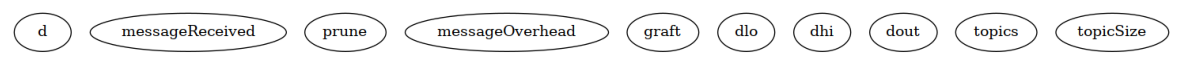

In [224]:
diff_p_s = nx.difference(parallel, stable)

A = nx.nx_agraph.to_agraph(diff_p_s)

A.layout("dot")

A.get_node('d').attr['style']='bold'
A.get_node('dlo').attr['style']='bold'
A.get_node('dhi').attr['style']='bold'
A.get_node('dout').attr['style']='bold'
# A.get_node('interval').attr['style']='bold'
A.get_node('topicSize').attr['style']='bold'
A.get_node('topics').attr['style']='bold'


A.get_node('messageOverhead').attr['style']='filled'
A.get_node('messageOverhead').attr['penwidth']=2

G=gcm.util.plot(diff_p_s, figure_size=[15, 10])
A.draw("./Graphs/diff_parallel_stable.png")#, prog="dot")

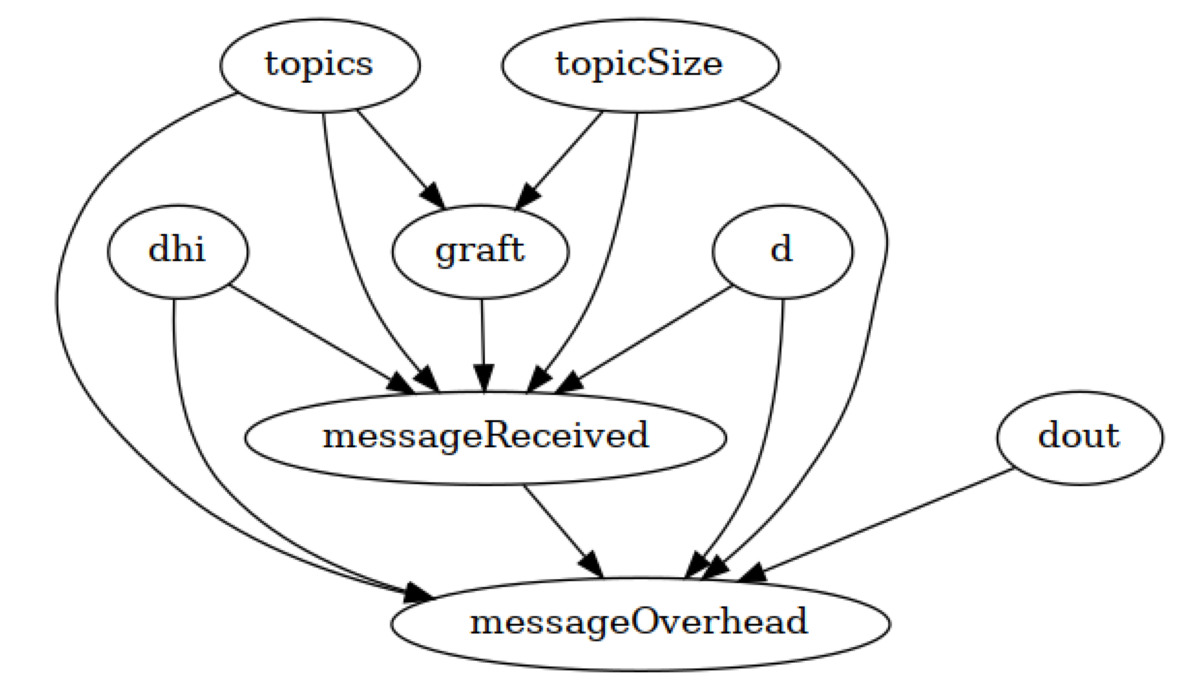

In [243]:
intersection_pc1 = nx.intersection(parallel, stable)
intersection_pc2 = nx.intersection(parallel, classic)
intersection_pc12 = nx.intersection(intersection_pc1, intersection_pc2)

intersection_pc3 = nx.intersection(classic, stable)
intersection_pc = nx.intersection(intersection_pc12, intersection_pc3)

# intersection_pc.remove_node("dlo")
intersection_pc.remove_node("prune")
intersection_pc.remove_node("dlo")

A = nx.nx_agraph.to_agraph(intersection_pc)

A.layout("dot")

A.get_node('d').attr['style']='bold'
# A.get_node('dlo').attr['style']='bold'
A.get_node('dhi').attr['style']='bold'
A.get_node('dout').attr['style']='bold'
# A.get_node('interval').attr['style']='bold'
A.get_node('topicSize').attr['style']='bold'
A.get_node('topics').attr['style']='bold'


A.get_node('messageOverhead').attr['style']='filled'
A.get_node('messageOverhead').attr['penwidth']=2

nx.write_adjlist(H, "./AdjLists/intersection_pc.adjlist")

G=gcm.util.plot(intersection_pc, figure_size=[15, 10])
A.draw("./Graphs/intersection_pc.png")#, prog="dot")

# Differences and Intersection between PC and manual

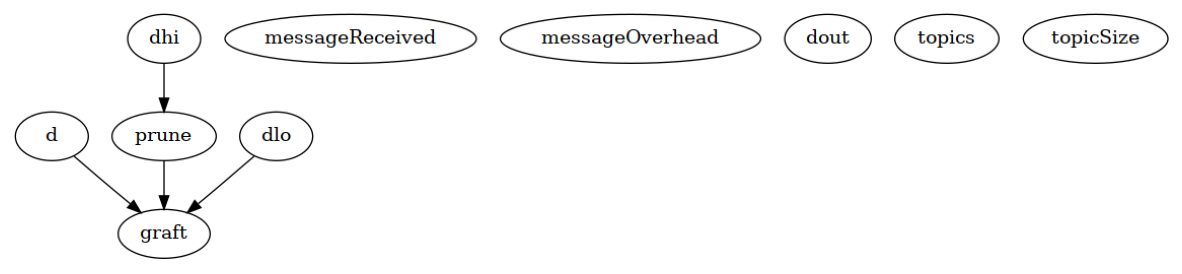

In [244]:
#PC and PD diff generate the same grpah. Log has an issue with inf values, so we only analyze pc and manual
# Nodes are in the same order in both files

manual = nx.read_adjlist("./AdjLists/manual.adjlist", create_using=nx.DiGraph)
pc = nx.read_adjlist("./AdjLists/intersection_pc.adjlist", create_using=nx.DiGraph)

#Edges in manual that are not in PC
diff1 = nx.difference(manual, pc)

mapping = {0:'d',
            1:'messageReceived',
            2:'graft',
            3:'prune',
            4:'dlo',
            5:'dhi',
            6:'dout',
            # 7:'interval',
            7:'messageOverhead',
            8:'topics',
           9:'topicSize'
          }

diff1_rename = nx.relabel_nodes(diff1, mapping)
G=gcm.util.plot(diff1_rename, figure_size=[15, 10])

A = nx.nx_agraph.to_agraph(diff1)

A.layout("dot")

A.get_node('d').attr['style']='bold'
A.get_node('dlo').attr['style']='bold'
A.get_node('dhi').attr['style']='bold'
A.get_node('dout').attr['style']='bold'
# A.get_node('interval').attr['style']='bold'
A.get_node('topicSize').attr['style']='bold'
A.get_node('topics').attr['style']='bold'


A.get_node('messageOverhead').attr['style']='filled'
A.get_node('messageOverhead').attr['penwidth']=2

A.draw("./Graphs/diff_manual_pc.png")#, prog="dot")



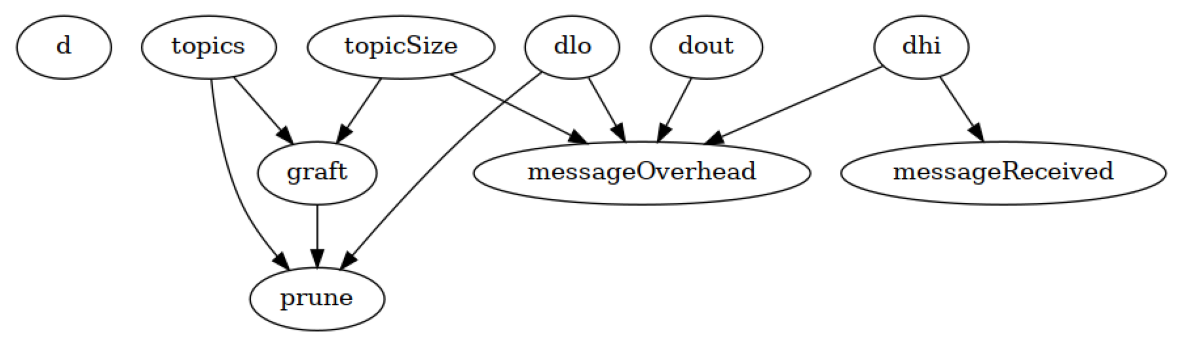

In [245]:
#Edges in pc that are not in manual
diff2 = nx.difference(pc, manual)

mapping = {0:'d',
            1:'messageReceived',
            2:'graft',
            3:'prune',
            4:'dlo',
            5:'dhi',
            6:'dout',
            # 7:'interval',
            7:'messageOverhead',
            8:'topics',
           9:'topicSize'
          }

diff2_rename= nx.relabel_nodes(diff2, mapping)
G=gcm.util.plot(diff2_rename, figure_size=[15, 10])     

A = nx.nx_agraph.to_agraph(diff2)

A.layout("dot")

A.get_node('d').attr['style']='bold'
A.get_node('dlo').attr['style']='bold'
A.get_node('dhi').attr['style']='bold'
A.get_node('dout').attr['style']='bold'
# A.get_node('interval').attr['style']='bold'
A.get_node('topicSize').attr['style']='bold'
A.get_node('topics').attr['style']='bold'


A.get_node('messageOverhead').attr['style']='filled'
A.get_node('messageOverhead').attr['penwidth']=2

A.draw("./Graphs/diff_pc_manual.png")#, prog="dot")

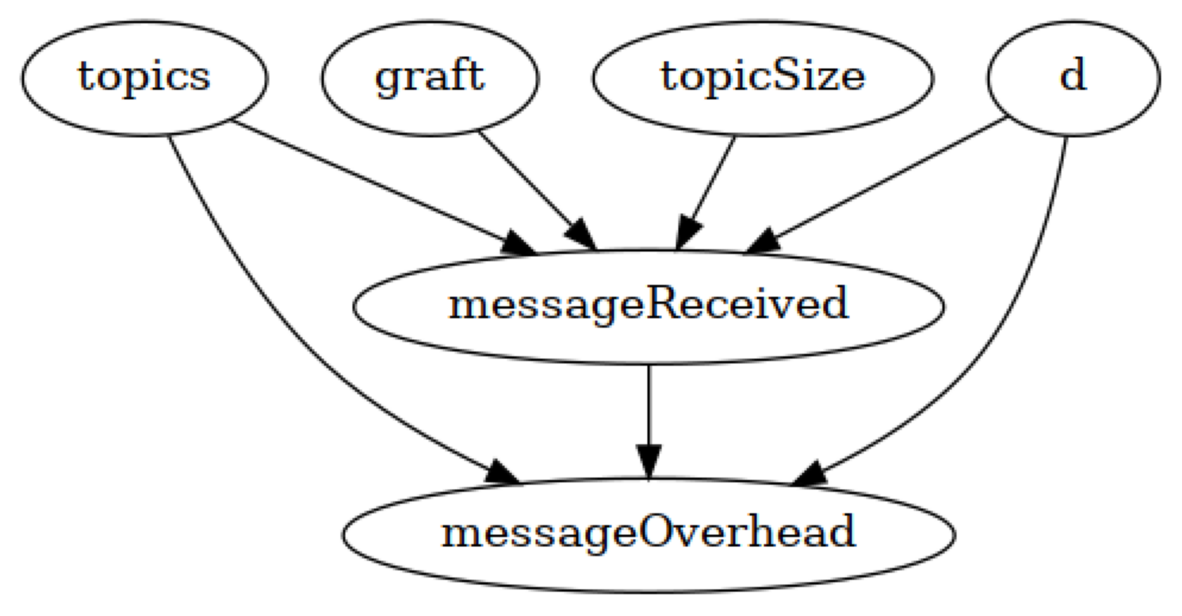

In [246]:
#Generate overlap graph
intersection = nx.intersection(manual, pc)

mapping = {0:'d',
            1:'messageReceived',
            2:'graft',
            3:'prune',
            4:'dlo',
            5:'dhi',
            6:'dout',
            # 7:'interval',
            7:'messageOverhead',
            8:'topics',
           9:'topicSize'
          }

intersection_rename = nx.relabel_nodes(intersection, mapping)

intersection_rename.remove_node('dhi')
intersection_rename.remove_node('dlo')
intersection_rename.remove_node('prune')
intersection_rename.remove_node('dout')

G=gcm.util.plot(intersection_rename, figure_size=[15, 10])

nx.write_adjlist(intersection_rename, "./AdjLists/intersection.adjlist")

A = nx.nx_agraph.to_agraph(intersection)

A.layout("dot")

A.get_node('d').attr['style']='bold'
A.get_node('dlo').attr['style']='bold'
A.get_node('dhi').attr['style']='bold'
A.get_node('dout').attr['style']='bold'
# A.get_node('interval').attr['style']='bold'
A.get_node('topicSize').attr['style']='bold'
A.get_node('topics').attr['style']='bold'


A.get_node('messageOverhead').attr['style']='filled'
A.get_node('messageOverhead').attr['penwidth']=2

A.draw("./Graphs/intersection.png")#, prog="dot")

In [247]:
# calculate metrics
intersection_matrix = nx.to_numpy_array(intersection)

mt = MetricsDAG(intersection_matrix, true_causal_matrix)
print(mt.metrics)

{'fdr': 0.7778, 'tpr': 0.1538, 'fpr': 0.2188, 'shd': 18, 'nnz': 9, 'precision': 0.2222, 'recall': 0.1538, 'F1': 0.1818, 'gscore': 0.0}
